# Imports

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Build the word vocab

In [3]:
data = open('/kaggle/input/mastruz-com-leite-letras/letras_clean.txt').read()

corpus = data.lower().split('\n')

print(corpus)

['o sertão de céu, o céu do sertão', 'se enche de viva de fogo e balão', 'se enche de viva "padim ciço" romão', 'caminhões de fé, carradas de devoção', 'bendito, bem dito, dito em aclamação', "a voz do padre cícero é 'enu' do sertão", 'valei meu padre cícero', 'e a mãe de deus das candeias', 'o sertão de céu, o céu do sertão', 'se enche de viva de fogo e balão', 'se enche de viva "padim ciço" romão', 'caminhões de fé, carradas de devoção', 'bendito, bem dito, dito em aclamação', "a voz do padre cícero é 'enu' do sertão", 'valei meu padre cícero', 'e a mãe de deus das candeias', 'o que caminho tão longe', 'tão cheio de pedra e areia', 'ontem sonhei contigo', 'me acordei na solidão', 'perdidamente em pensamento', 'quando o carteiro chegou', 'fiquei emocionado', 'senti uma onda de calor', 'ao receber sua carta', 'meu coração disparou.', 'você não me esqueceu', 'nem eu, nem eu, nem eu', 'você já sabe que é a dona', 'deste pobre coração', 'e de quanto eu te quero', 'você é minha paixão', '(

In [4]:
vectorize_layer = tf.keras.layers.TextVectorization()

vectorize_layer.adapt(corpus)

In [5]:
vocabulary = vectorize_layer.get_vocabulary()
vocab_size = len(vocabulary)

print(f'{vocabulary}')
print(f'{vocab_size}')

['', '[UNK]', 'que', 'o', 'eu', 'de', 'e', 'não', 'a', 'você', 'é', 'me', 'pra', 'meu', 'se', 'amor', 'um', 'te', 'no', 'do', 'com', 'em', 'só', 'vou', 'na', 'por', 'vai', 'coração', 'mais', 'da', 'mim', 'minha', 'quero', 'mas', 'uma', 'tem', 'teu', 'quando', 'seu', 'vem', 'sou', 'como', 'tudo', 'já', 'mulher', 'sem', 'gente', 'ser', 'tá', 'forró', 'foi', 'são', 'bem', 'ela', 'amar', 'sei', 'quem', 'assim', 'vida', 'os', 'ter', 'quer', 'tô', 'para', 'todo', 'esse', 'tão', 'nem', 'as', 'nosso', 'dia', 'lá', 'sempre', 'sua', 'toda', 'faz', 'está', 'ele', 'ai', 'era', 'mundo', 'agora', 'noite', 'estou', 'paixão', 'joão', 'feliz', 'ver', 'tanto', 'pode', 'boi', 'tu', 'bom', 'ninguém', 'dizer', 'fazer', 'viver', 'dá', 'ao', 'dar', 'onde', 'tenho', 'saudade', 'tempo', 'nada', 'essa', 'ficar', 'esquecer', 'até', 'dançar', 'muito', 'jeito', 'ô', 'ah', 'nos', 'também', 'porque', 'nunca', 'fui', 'lua', 'alguém', 'lhe', 'fez', 'amo', 'vaqueiro', 'aqui', 'voltar', 'tua', 'olhar', 'nós', 'corpo', '

# Preprocessing the dataset

In [6]:
input_sequences = []

for line in corpus:
    sequence = vectorize_layer(line).numpy()
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])

input_sequences = np.array(tf.keras.utils.pad_sequences(input_sequences,
                                                       maxlen=max_sequence_len,
                                                       padding='pre'))

xs, labels = input_sequences[:,:-1], input_sequences[:, -1]

ys = tf.keras.utils.to_categorical(labels, num_classes=vocab_size)

In [7]:
def sequence_to_text(sequence, vocabulary):
    words = [vocabulary[index] for index in sequence]
    text = tf.strings.reduce_join(words, separator=' ').numpy().decode()
    return text

In [8]:
# Pick element
elem_number = 6

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [  0   0   0   0   0   0   0   0   3 139   5 137   3 137  19]
decoded to text:         o sertão de céu o céu do
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 139


In [9]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {sequence_to_text(xs[elem_number], vocabulary)}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [  0   0   0   0   0   0   0   0   0   3 139   5 137   3 137]
decoded to text:          o sertão de céu o céu
one-hot label: [0. 0. 0. ... 0. 0. 0.]
index of label: 19


In [10]:
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 32

dataset = tf.data.Dataset.from_tensor_slices((xs,ys))

dataset = dataset.cache().prefetch(PREFETCH_BUFFER_SIZE).batch(BATCH_SIZE)

# Build and compile the Model

In [11]:
# params
embedding_dim = 100
lstm_units = 150
learning_rate = 0.01

# build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(max_sequence_len-1,)),
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units)),
    tf.keras.layers.Dense(vocab_size, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    # optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 15, 100)             │         577,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 300)                 │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5776)                │       1,738,576 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,617,376 (9.98 MB)

 Trainable params: 2,617,376 (9.98 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [12]:
epochs = 100

history = model.fit(dataset, epochs=epochs)

Epoch 1/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.0316 - loss: 6.8840
Epoch 2/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.0645 - loss: 5.8481
Epoch 3/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.0989 - loss: 5.2577
Epoch 4/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.1344 - loss: 4.7767
Epoch 5/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.1753 - loss: 4.3157
Epoch 6/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.2250 - loss: 3.8891
Epoch 7/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.2791 - loss: 3.5156
Epoch 8/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3332 - loss: 3.1866
Epoch 9/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.3796 - loss: 2.9240
Epoch 10/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.4273 - loss: 2.6886
Epoch 11/100
1857/1857 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.4610 - loss: 2.5070
Epoch 12

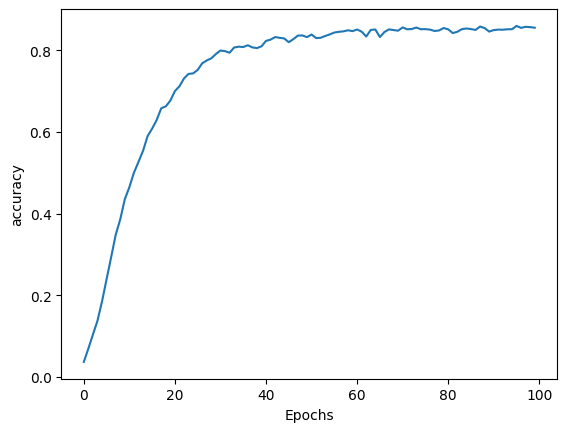

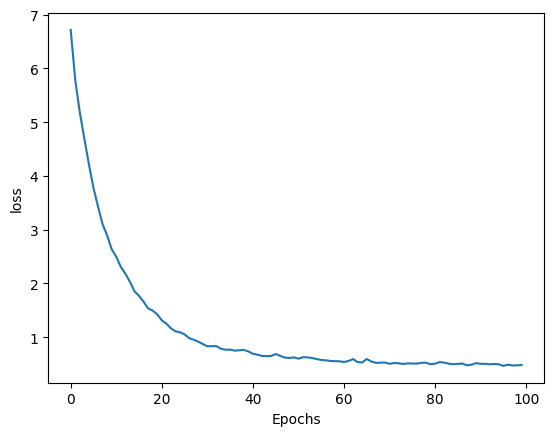

In [19]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [20]:
# Define seed text
seed_text = "eu nao sei aonde estou"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Generate the integer sequence of the current line
	sequence = vectorize_layer(seed_text)

	# Pad the sequence
	sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(sequence, verbose=0)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:

		# Look up the word associated with the index.
		output_word = vocabulary[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result
print(seed_text)

eu nao sei aonde estou apaixonada um só instante um desejo a seu conheci é prazer hospital sempre era explicar muita achar que você podem fome na fome dos teus passos sobre fome a fome a fome a pimba nela porque é fome das rosa aconteceu contigo aconteceu desligar pra me mostrar pra lo jornal publicar num forró trem bom sertão de fazenda cada dia vai enganar meu distante de verdadeiro amar pra gente voltar já cá no acredito que caneta de fim voando pra o meu amor entregar totalmente à você pra cá meu palha no fim de fome no fome fazendo nordeste apareceu


In [21]:
# Define seed text
seed_text = "Você é minha luz, meu sol e minha estrela"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to an integer sequence
  sequence = vectorize_layer(seed_text)

	# Pad the sequence
  sequence = tf.keras.utils.pad_sequences([sequence], maxlen=max_sequence_len-1, padding='pre')

	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(sequence, verbose=0)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])

  # Sort the probabilities in ascending order
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:

    # Look up the word associated with the index.
    output_word = vocabulary[predicted]

    # Combine with the seed text
    seed_text += " " + output_word

# Print the result
print(seed_text)

Você é minha luz, meu sol e minha estrela te oração navegar a a gente encontrar que te luar forró mal me levou coragem de carro prazer te vejo de dedo eu tenho sem boca pra você sentia virei embora de fim grande saudade pão fim jogar tão incendeia tanto viver e me fome não amigos é embora pra machucar minha solidão sem a minha olhar não me rua quase dançar fogo e o sertão vai dar fome de meu nós meus dois eu abro de ti agora quem passei de pau alegria perdida na esteira meu fim aconteceu do coração mas sou minha lembrança é um vulcão é
